In [39]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns


# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler.joblib')
iso_model = load('./model/iso_model.joblib')

# Load datasets
#df_val = pd.read_csv("./data/validate.csv")

df_val = pd.read_csv("./data/devAll2_prepared.csv")

In [40]:
df_val

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933
...,...,...,...,...,...,...,...,...,...
301186,2025-06-29 20:25:27.980,101.0,27.900000,0.0,29.101625,81.113754,2.490953,8.638010,99.898972
301187,2025-06-29 20:25:48.980,102.0,25.600000,0.0,29.908064,77.426796,3.856516,8.637931,99.898941
301188,2025-06-29 20:26:01.100,102.0,25.600000,0.0,29.349968,80.005569,2.614293,8.637931,99.898949
301189,2025-06-29 20:26:02.150,101.0,27.900000,0.0,29.050890,81.302589,8.617684,8.638011,99.898972


In [41]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo,lat,lng
count,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000
mean,101.503282,48.952394,0.205600,29.871124,75.252266,8.128838,8.637978,99.898949
std,0.499990,10.397376,1.761622,3.193456,8.565651,6.716052,0.000038,0.001335
min,101.000000,21.100000,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664
25%,101.000000,44.200001,0.000000,27.368584,69.429153,3.009754,8.637945,99.898926
50%,102.000000,50.400002,0.000000,28.508812,79.240715,4.383256,8.637974,99.898949
75%,102.000000,57.799999,0.000000,32.749290,81.176704,13.366670,8.638014,99.898972
max,102.000000,66.599998,41.630600,38.984512,88.510567,32.062466,8.638361,99.900078


## Threshold

In [42]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.5)
#warn_thresh = np.percentile(df_val['anomaly_score'], 5)

crit_thresh = -0.08836725668910894 
warn_thresh = 0.025479414819127754 

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)

print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.5))
print("warn_thresh:", np.percentile(df_val['anomaly_score'], 5))

crit_thresh: -0.0886865249280855
warn_thresh: 0.0255929274758136


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


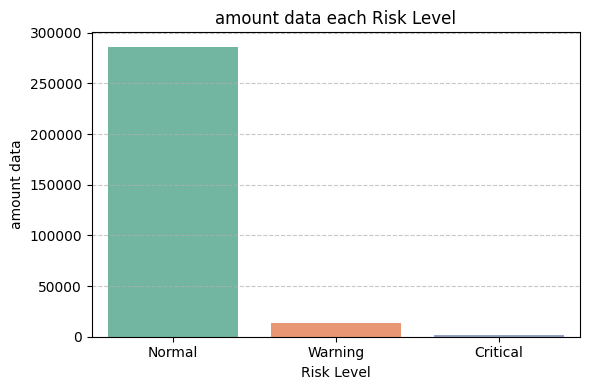

In [43]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

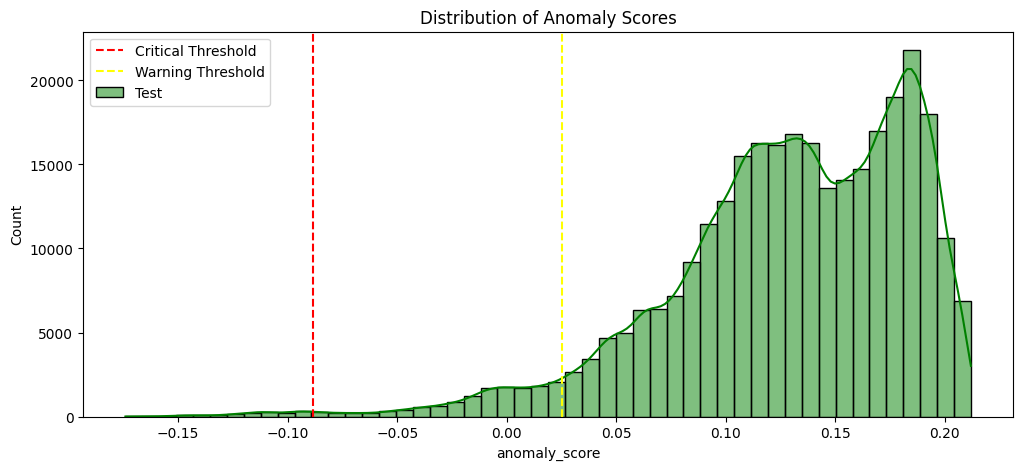

In [44]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## Z-score Outlier

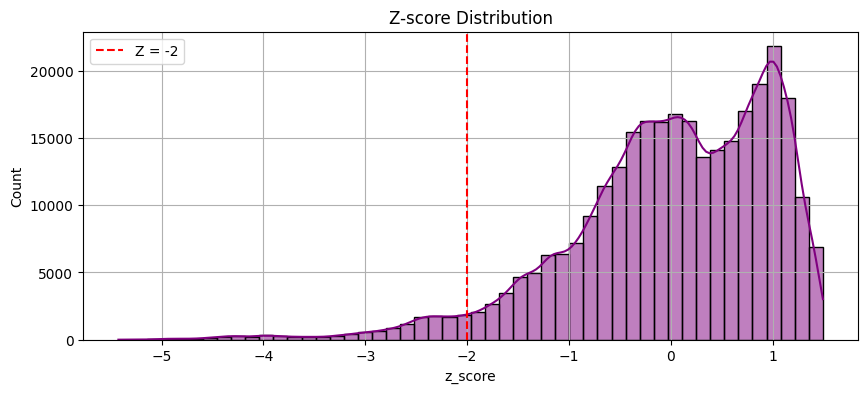

In [45]:
# ==== Z-score Outlier ====

mean_score = df_val['anomaly_score'].mean()
std_score = df_val['anomaly_score'].std()
df_val['z_score'] = (df_val['anomaly_score'] - mean_score) / std_score
df_val['z_outlier'] = df_val['z_score'].apply(lambda z: 'Anomaly' if z < -2 else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['z_score'], kde=True, bins=50, color='purple')
plt.axvline(-2, color='red', linestyle='--', label='Z = -2')
plt.title("Z-score Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Mahalanobis Distance

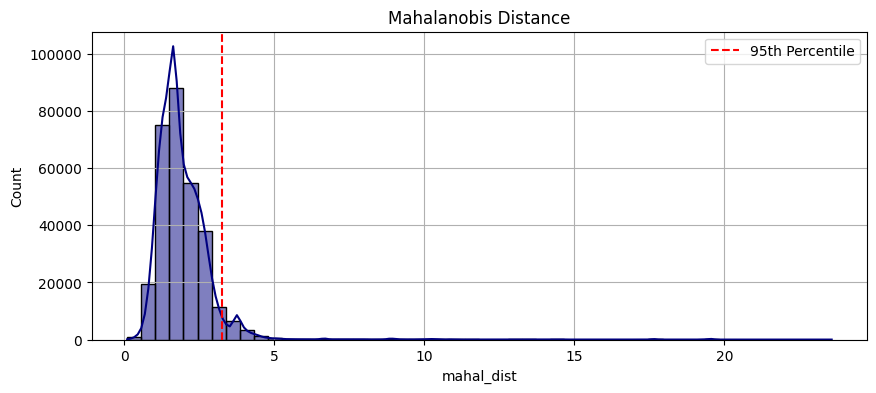

In [46]:
mean_vec = np.mean(X_val_scaled, axis=0)
cov_matrix = np.cov(X_val_scaled, rowvar=False)
inv_covmat = np.linalg.inv(cov_matrix)

df_val['mahal_dist'] = [mahalanobis(x, mean_vec, inv_covmat) for x in X_val_scaled]
mahal_thresh = np.percentile(df_val['mahal_dist'], 95)
df_val['mahal_outlier'] = df_val['mahal_dist'].apply(lambda d: 'Anomaly' if d > mahal_thresh else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['mahal_dist'], bins=50, kde=True, color='navy')
plt.axvline(mahal_thresh, color='red', linestyle='--', label='95th Percentile')
plt.title("Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()

## Percentile Threshold 5%

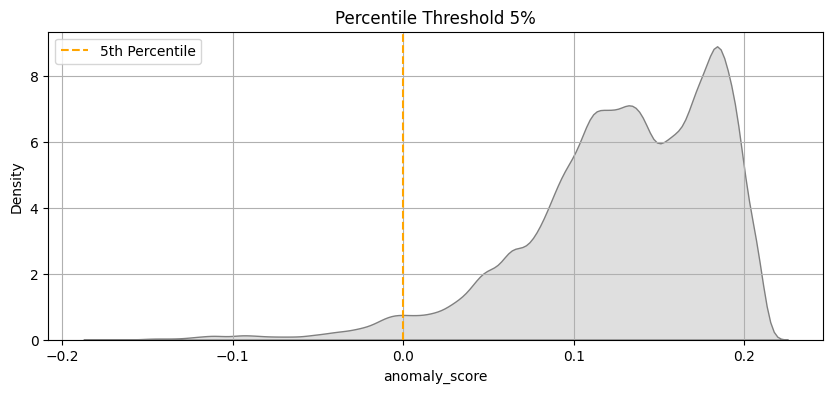

In [47]:
percentile = np.percentile(df_val['anomaly_score'], 3)
df_val['percentile_outlier'] = df_val['anomaly_score'].apply(lambda s: 'Anomaly' if s < percentile else 'Normal')

plt.figure(figsize=(10,4))
sns.kdeplot(df_val['anomaly_score'], fill=True, color='gray')
plt.axvline(percentile, color='orange', linestyle='--', label='5th Percentile')
plt.title("Percentile Threshold 5%")
plt.legend()
plt.grid(True)
plt.show()

## PCA

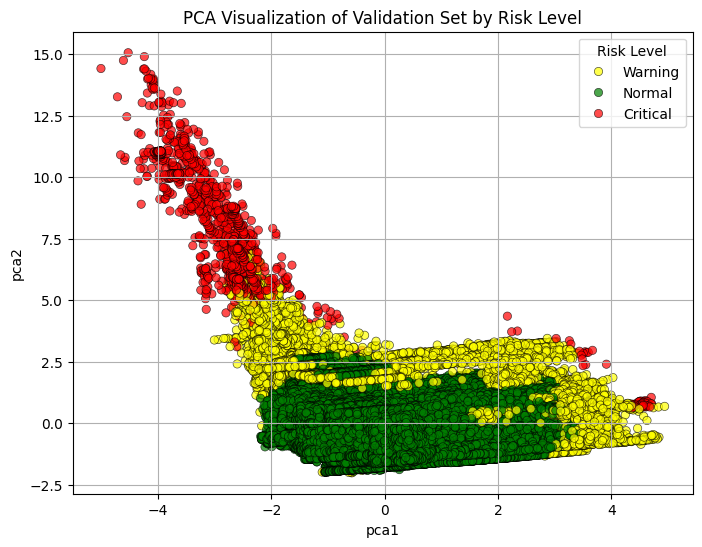

In [48]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [49]:
explained_var = pca.explained_variance_ratio_
print(f"PCA explain {explained_var[0]*100:.2f}% and {explained_var[1]*100:.2f}% of data")


PCA explain 39.97% and 22.23% of data


In [50]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
temp  0.687328  0.109401
geo  -0.008019  0.685443
rain -0.136205  0.592757
soil -0.229066  0.381586
humi -0.675643 -0.145708


## Summary Statistics

In [51]:
print("\n== Z-score Outlier ==")
print(df_val['z_outlier'].value_counts())


== Z-score Outlier ==
z_outlier
Normal     288331
Anomaly     12860
Name: count, dtype: int64


In [52]:
print("\n== Percentile Outlier ==")
print(f"5th Percentile Threshold: {percentile:.4f}")
print(df_val['percentile_outlier'].value_counts())


== Percentile Outlier ==
5th Percentile Threshold: 0.0001
percentile_outlier
Normal     292155
Anomaly      9036
Name: count, dtype: int64


In [53]:
print("\n== Mahalanobis Outlier ==")
print(f"95th Percentile of Mahalanobis Distance: {mahal_thresh:.2f}")
print(df_val['mahal_outlier'].value_counts())


== Mahalanobis Outlier ==
95th Percentile of Mahalanobis Distance: 3.27
mahal_outlier
Normal     286131
Anomaly     15060
Name: count, dtype: int64


In [54]:
overlap = df_val[
    (df_val['z_outlier'] == 'Anomaly') &
    (df_val['percentile_outlier'] == 'Anomaly') &
    (df_val['mahal_outlier'] == 'Anomaly')
]
print(f"Anomalies detected by ALL 3 methods: {len(overlap)}")


Anomalies detected by ALL 3 methods: 7103


In [55]:
df_val['combined_outlier'] = df_val.apply(
    lambda row: (
        row['z_outlier'] == 'Anomaly' or
        row['percentile_outlier'] == 'Anomaly' or
        row['mahal_outlier'] == 'Anomaly'
    ),
    axis=1
)

print("\n== Combined Outlier ==")
print(df_val['combined_outlier'].value_counts())


== Combined Outlier ==
combined_outlier
False    281832
True      19359
Name: count, dtype: int64


In [56]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo
predicted_risk                                                       
Critical        54.801582  19.948092  27.368693  79.788561  17.796504
Normal          49.155023   0.034241  29.742696  75.639598   7.715271
Warning         44.005113   1.617973  32.871511  66.541258  15.800921


In [57]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      286160
Warning      13514
Critical      1517
Name: count, dtype: int64


In [58]:
def risk_from_combined(row):
    if row['combined_outlier']:
        if row['anomaly_score'] < crit_thresh:
            return 'Critical'
        elif row['anomaly_score'] < warn_thresh:
            return 'Warning'
        else:
            return 'Warning'  
    return 'Normal'

df_val['risk_level_final'] = df_val.apply(risk_from_combined, axis=1)
print("\n== risk level final ==")
print(df_val['risk_level_final'].value_counts())


== risk level final ==
risk_level_final
Normal      281832
Warning      17842
Critical      1517
Name: count, dtype: int64


In [59]:
print("\n== Risk final Proportion ==")
print("Validation:", df_val['risk_level_final'].value_counts(normalize=True))


== Risk final Proportion ==
Validation: risk_level_final
Normal      0.935725
Warning     0.059238
Critical    0.005037
Name: proportion, dtype: float64


In [60]:
print("\n== Risk Proportion ==")
print("Validation:", df_val['predicted_risk'].value_counts(normalize=True))


== Risk Proportion ==
Validation: predicted_risk
Normal      0.950095
Warning     0.044869
Critical    0.005037
Name: proportion, dtype: float64


##  Signal-to-Noise Ratio (SNR)

In [61]:
def compute_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal if std_signal != 0 else 0

for col in feature_cols:
    snr = compute_snr(df_val[col])
    print(f"SNR of {col}: {snr:.2f}")


SNR of soil: 4.71
SNR of rain: 0.12
SNR of temp: 9.35
SNR of humi: 8.79
SNR of geo: 1.21


In [62]:
for col in feature_cols:
    normal_snr = compute_snr(df_val[df_val['predicted_risk'] == 'Normal'][col])
    anomaly_snr = compute_snr(df_val[df_val['predicted_risk'] != 'Normal'][col])
    print(f"{col}: Normal SNR={normal_snr:.2f}, Anomaly SNR={anomaly_snr:.2f}")


soil: Normal SNR=4.86, Anomaly SNR=3.15
rain: Normal SNR=0.14, Anomaly SNR=0.49
temp: Normal SNR=9.70, Anomaly SNR=7.40
humi: Normal SNR=9.32, Anomaly SNR=5.40
geo: Normal SNR=1.26, Anomaly SNR=1.46


## Mean Absolute Error (MAE)

In [63]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
interval = df_val['timestamp'].diff().median()
print(f"Sampling interval: {interval}")


Sampling interval: 0 days 00:00:06.130000


In [64]:
window_size = int(pd.Timedelta('1H') / interval)
print(f"Rolling window size for 1 hour: {window_size}")


Rolling window size for 1 hour: 587


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\504831528.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


In [65]:
interval = df_val['timestamp'].diff().median()
window_size = int(pd.Timedelta('1H') / interval)

print(f"Using rolling window size = {window_size} for 1 hour")

for col in feature_cols:
    df_val[f'{col}_roll_mean'] = df_val[col].rolling(window=window_size, center=True).mean()
    df_val[f'{col}_mae'] = (df_val[col] - df_val[f'{col}_roll_mean']).abs()

    mae = df_val[f'{col}_mae'].mean()
    print(f"MAE for {col} (vs rolling mean): {mae:.2f}")


Using rolling window size = 587 for 1 hour
MAE for soil (vs rolling mean): 1.97
MAE for rain (vs rolling mean): 0.15
MAE for temp (vs rolling mean): 0.42
MAE for humi (vs rolling mean): 1.76
MAE for geo (vs rolling mean): 5.23


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\2248412977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


## Cross-Correlation

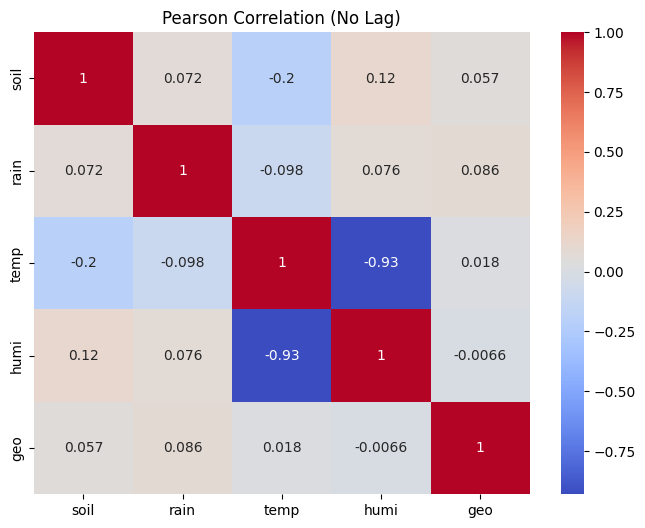

In [66]:
corr_matrix = df_val[feature_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation (No Lag)")
plt.show()

In [67]:
def lag_corr(x, y, max_lag=window_size*10):
    lags = []
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        lags.append(lag)
        corrs.append(corr)
    return lags, corrs


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\1202832202.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\1202832202.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


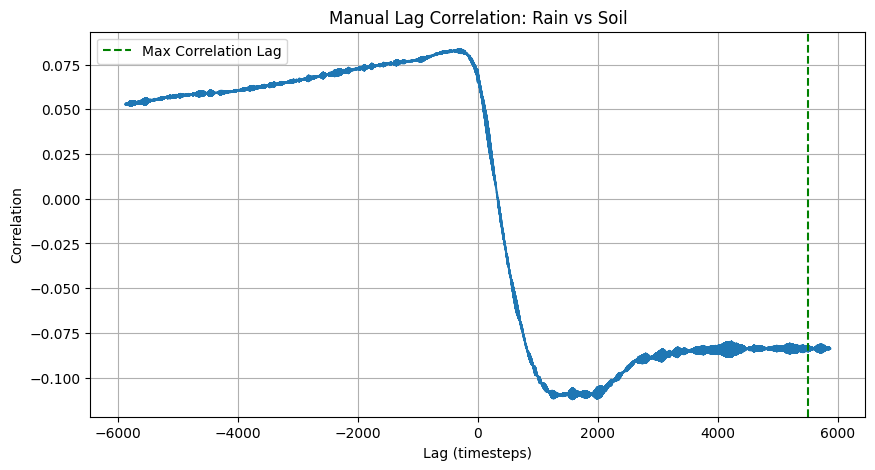

In [68]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values
lags, corrs = lag_corr(x, y, max_lag=window_size*10)

plt.figure(figsize=(10, 5))
plt.plot(lags, corrs)
plt.axvline(x=np.argmax(corrs) - 60, color='green', linestyle='--', label='Max Correlation Lag')
plt.title("Manual Lag Correlation: Rain vs Soil")
plt.xlabel("Lag (timesteps)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\3179048846.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\3179048846.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


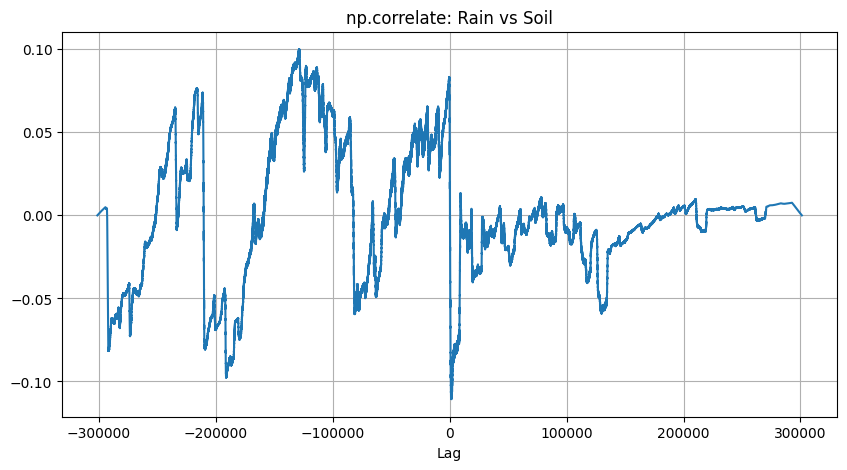

In [69]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

corr = np.correlate(x, y, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

plt.figure(figsize=(10,5))
plt.plot(lags, corr)
plt.title("np.correlate: Rain vs Soil")
plt.xlabel("Lag")
plt.grid(True)
plt.show()


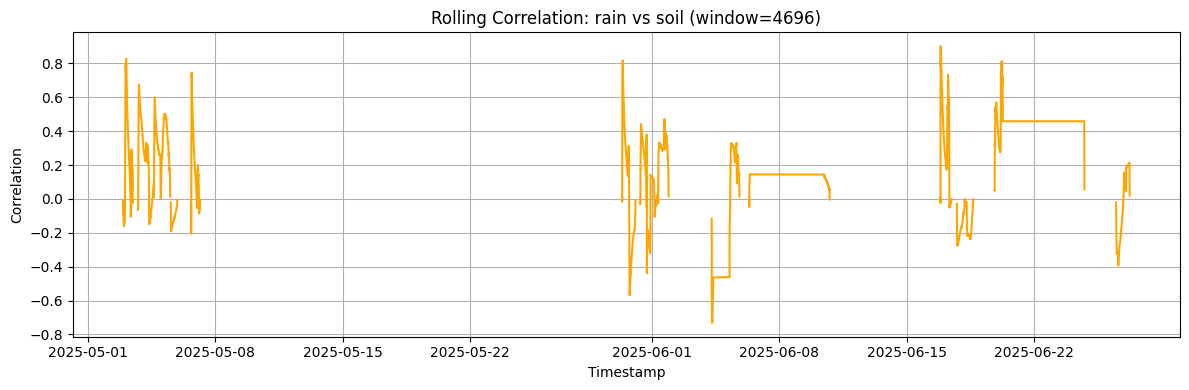

In [70]:
# ตัวอย่าง: ถ้า sampling ทุก 10 นาที → 48 จุด = 8 ชั่วโมง
df = df_val.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

rolling_corr = df['rain'].rolling(window_size*8).corr(df['soil'])

plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], rolling_corr, color='orange')
plt.title(f"Rolling Correlation: rain vs soil (window={window_size*8})")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

## histogram

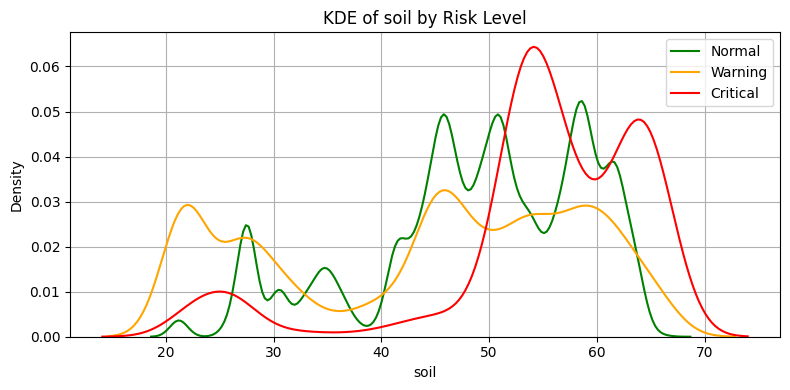

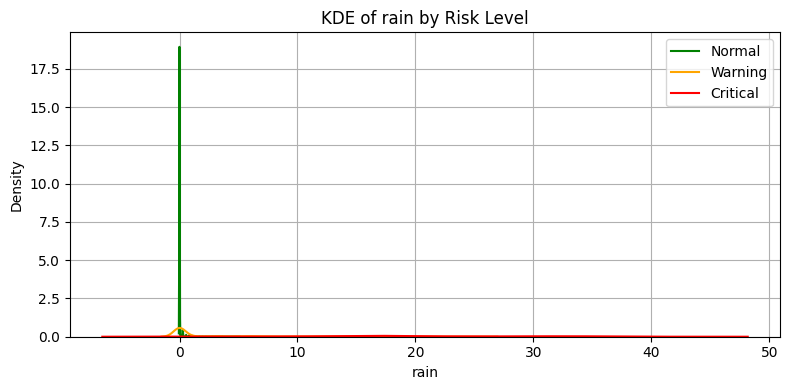

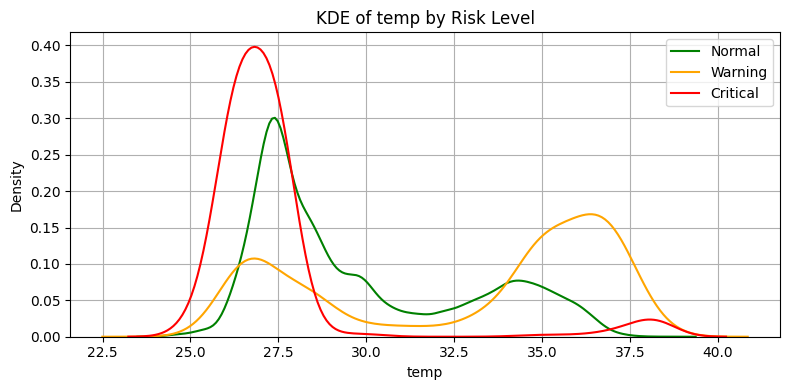

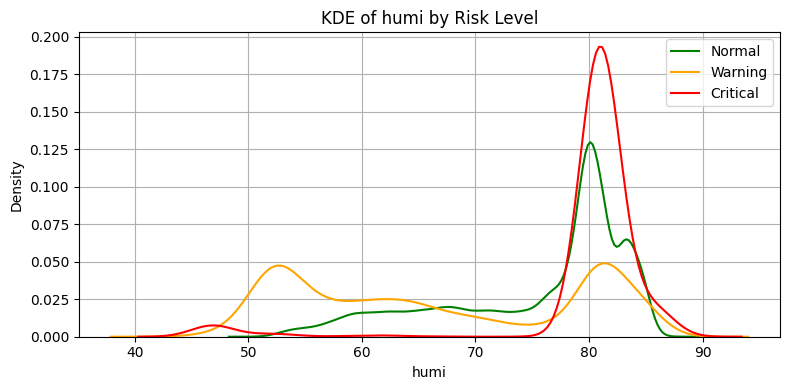

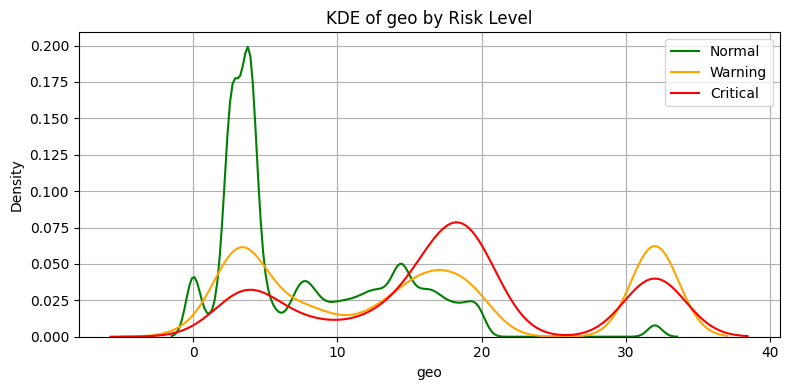

In [71]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\3156544813.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_risk', y=col, data=df_val, palette='Set2')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\3156544813.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_risk', y=col, data=df_val, palette='Set2')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_10292\3156544813.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_risk', y=col, data=df_val, palette='Set2')
C:\Users\ahmad\AppData\Local\Temp\ipyker

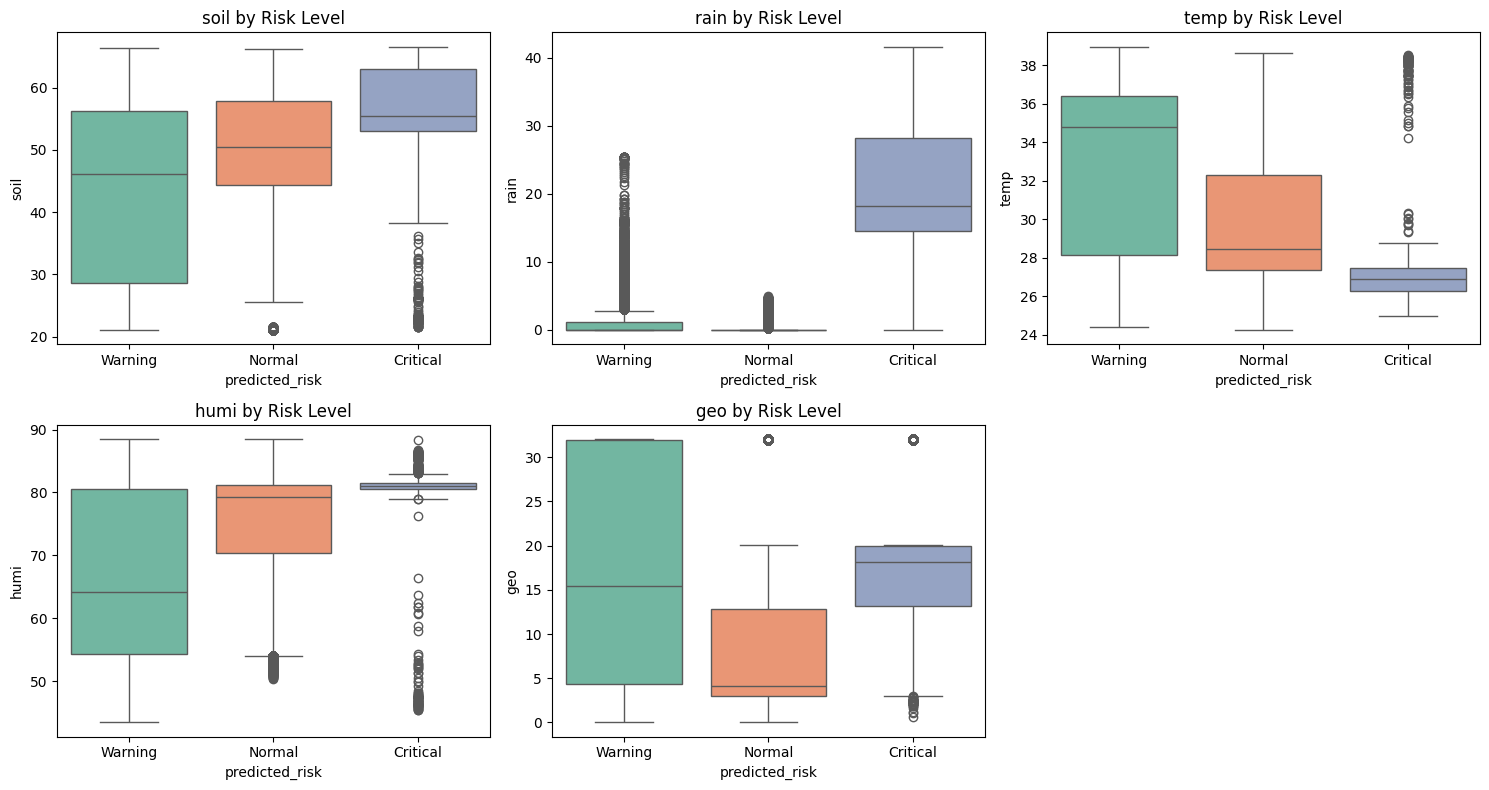

In [72]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='predicted_risk', y=col, data=df_val, palette='Set2')
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()

## Time Series

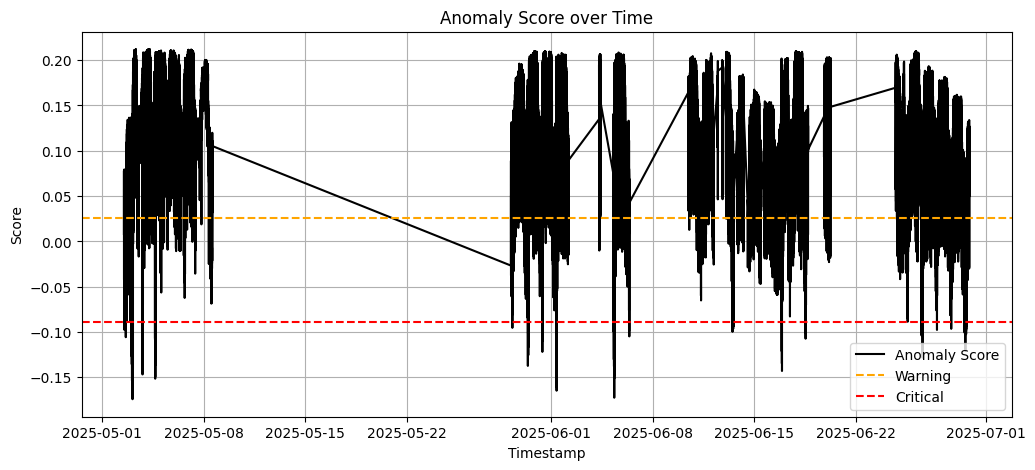

In [73]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

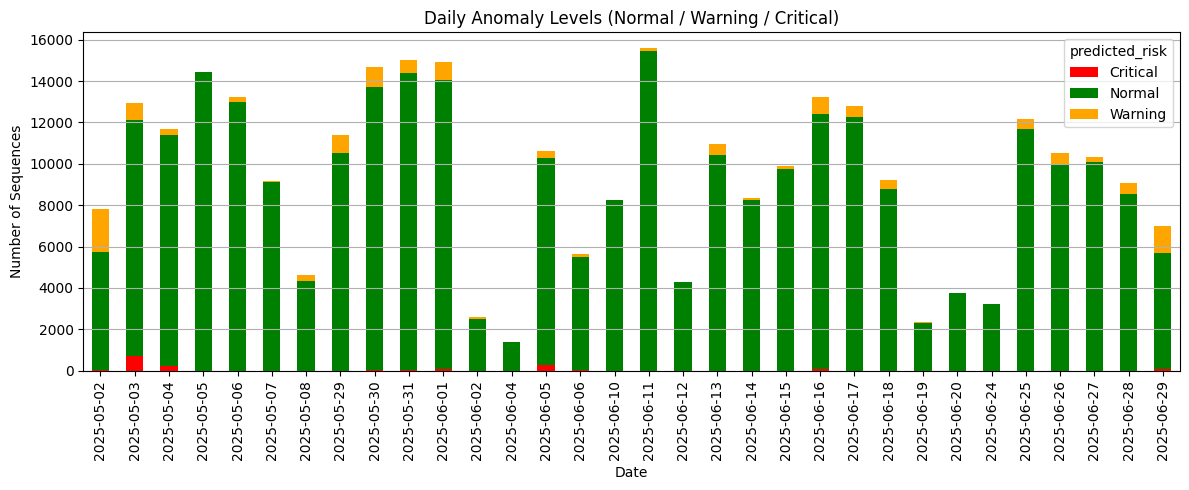

In [74]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


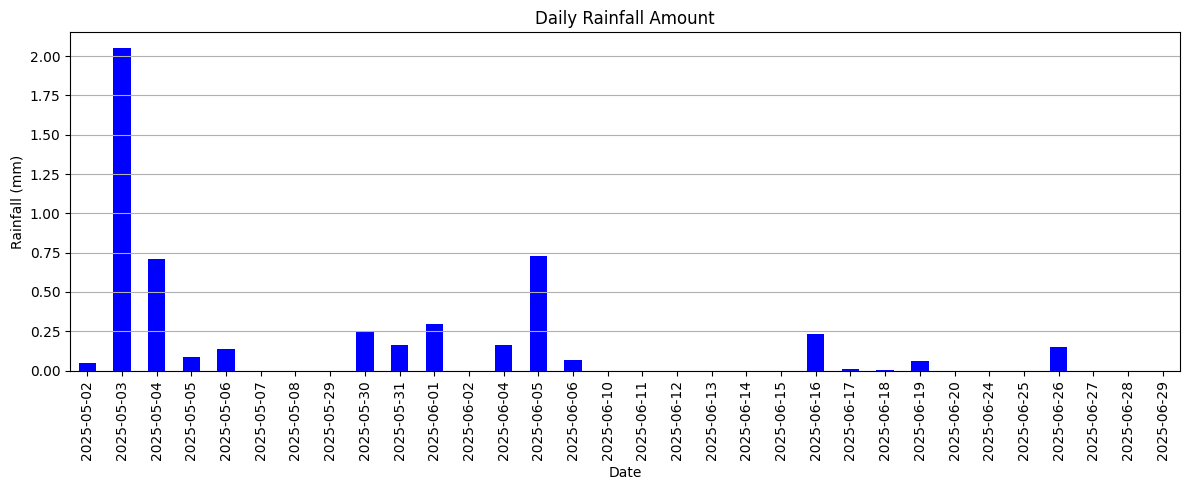

In [75]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


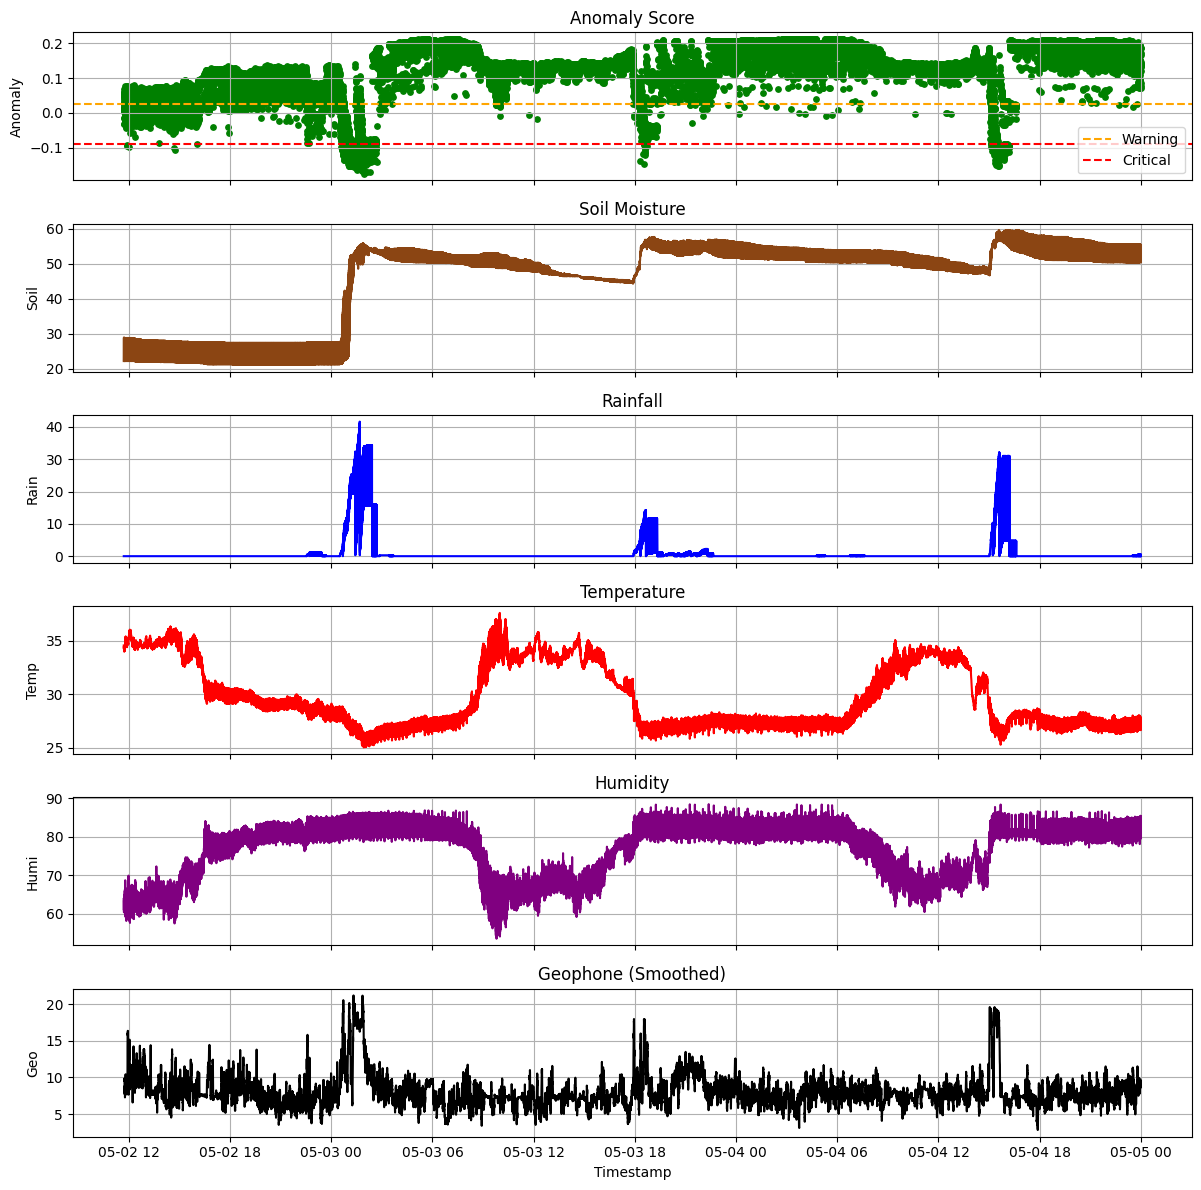

In [76]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_range = df_dev.loc["2025-05-02":"2025-05-04"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()
